In [ ]:
import os
import cv2
import math
import numpy as np
import natsort
import matplotlib.pyplot as plt
from scipy.io import loadmat
from collections import Counter
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans

In [ ]:
#connecting to drive
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/pattern/BSR_bsds500/BSR/BSDS500/data'
images_path = '/content/gdrive/MyDrive/pattern/BSR_bsds500/BSR/BSDS500/data/images'
groundTruth_path='/content/gdrive/MyDrive/pattern/BSR_bsds500/BSR/BSDS500/data/groundTruth'

Mounted at /content/gdrive


In [ ]:
def get_images(path,n,dir) :

    path=os.path.join(images_path , dir)

    images=[]
    pixels=[]

    for root, dirs, files in sorted(os.walk(path)): 
      files = natsort.natsorted(files)
      for i in range(n):
          #print(files[i])
          curr_imgPath = os.path.join(root, files[i])
          #read image and convert it to RGB
          image = cv2.imread(curr_imgPath)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
          pixel = image.reshape((-1,3))
          pixel = np.float32(pixel)

          images.append(image)
          pixels.append(pixel)


    return images , pixels

In [ ]:
def get_groundTruths(path,n,dir) : 
    path=os.path.join(groundTruth_path , dir)

    Segmentation=[]
    Boundaries=[]
    
    for root, dirs, files in sorted(os.walk(path)): 
      files = natsort.natsorted(files)
      for i in range(n):
          #print(files[i])
          data = loadmat(os.path.join(root, files[i]))
          groundTruth = data['groundTruth']
          seg=[]
          bound=[]
          for arr1 in groundTruth :
              for arr2 in arr1 : 
                  seg.append(arr2[0][0][0])
                  bound.append(arr2[0][0][1]) 
          Segmentation.append(seg)
          Boundaries.append(bound)

    return Segmentation , Boundaries

In [ ]:
def get_dataset(n,dir) : 
  img,pix = get_images(images_path,n,dir)
  seg,bound=get_groundTruths(groundTruth_path,n,dir)
  return img,pix,seg,bound


In [ ]:
def show_segmentation(image) :
    for img in image : 
        plt.imshow(img)
        plt.show()
    plt.close()

In [ ]:
def show_boundaries(image):
    for img in image : 
        plt.imshow(img,cmap='gray_r')
        plt.show()
    plt.close()

In [ ]:
def print_image(img,seg,bound) : 
    print("Real Image")
    plt.imshow(img)
    plt.show()
    print("Segmentation")
    show_segmentation(seg)
    # print("Boundaries")
    # show_boundaries(bound)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [5 5 5 ... 3 3 3]
 [5 5 5 ... 3 3 3]
 [5 5 5 ... 3 3 3]]
Real Image


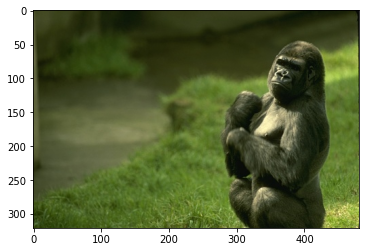

Segmentation


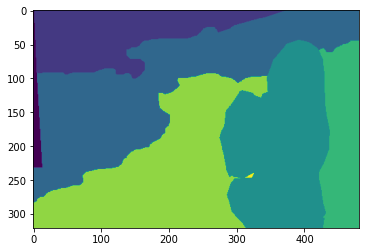

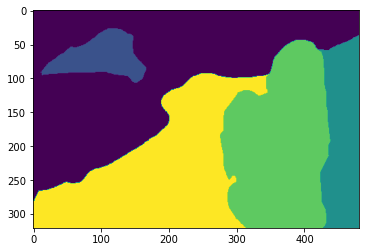

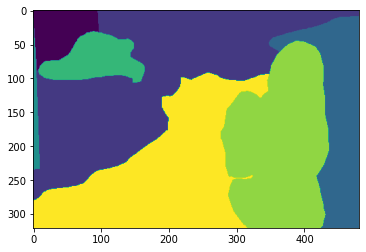

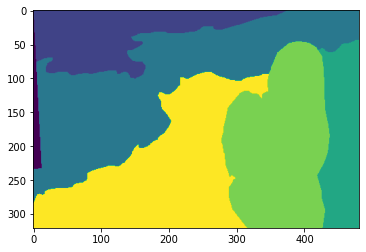

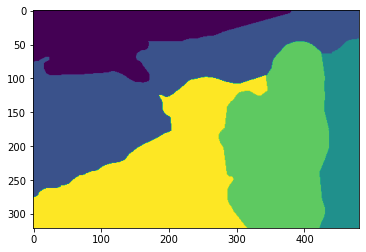

In [ ]:
#number of samples and wanted directory
n=50
dir='test'
images_data,pixels_data,seg_data,bound_data = get_dataset(n,dir)
#print(pixels_data[0].shape)
print(seg_data[30][1])
#print(np.unique(seg_data[3][0]))
#index of wanted image to print
index = 30
print_image(images_data[index],seg_data[index],bound_data[index])

# **Saving Image to drive**

In [ ]:
def save_img(k,image, indx):
  plt.imsave("/content/gdrive/MyDrive/pattern/Assignment_2/Kmeans_segmentations/"+ str(k) + "/image" + str(indx) + ".jpg", image)

# **KMEANS**

In [ ]:
def get_centroids(k, D):
  centroids = []
  taken_pixels_indx = []
  while len(centroids) < k :
    rand_indx = np.random.randint(0, len(D))
    if rand_indx not in taken_pixels_indx :
       centroids.append(D[rand_indx])
  return centroids

In [ ]:
def assign_to_cluster(pixel, centroids):
  assigned_cluster = -1;
  min_distance = float('inf')
  for i in range (len(centroids)):
    distance = np.linalg.norm(pixel - centroids[i])
    if distance < min_distance :
      min_distance = distance
      assigned_cluster = i
  return assigned_cluster

In [ ]:
def check_divergance(new_centroids, old_centroids, e):
  sum = np.sum(np.square(np.subtract(new_centroids, old_centroids)))
  return sum <= e

In [ ]:
def k_means(D, K, e):
  # get random centroids
  centroids = get_centroids(K, D)

  clusters = np.zeros(len(D))
  t = 0
  while( t <= 100):
    # print(centroids)
    C = []
    # creating empty clusters
    for i in range(K) :
      C.append([])

    # cluster assignment step
    for j in range(len(D)) :
      cluster = assign_to_cluster(D[j], centroids)
      clusters[j] = cluster
      C[cluster].append(D[j])
    
    
    # checking if there is an empty cluster random restart
    if len(Counter(clusters).keys()) < K :
      centroids = get_centroids(K, D)
      continue

    new_centroids = []
    # centroid update step
    for j in range(K) :
      new_centroids.append(np.sum(C[j], axis = 0) / len(C[j]))

    # if centroids are the same break
    # if sum(np.square(np.array(new_centroids) - np.array(centroids))) <= e :
    if check_divergance(new_centroids, centroids, e) :
      break

    centroids = new_centroids
    t += 1
  return clusters

In [ ]:
def from_1d_to_2d(cluster_assignment, original_image):
  return cluster_assignment.reshape((original_image.shape[0], original_image.shape[1]), order= 'C')

# **Evalutaion**

In [ ]:
def get_conditional_entropy(contingency_mat):
  rows=contingency_mat.shape[0]
  col=contingency_mat.shape[1]
  cond_entropy=0
  total_sum=np.sum(contingency_mat)
  for j in range (col):
    sum=np.sum(contingency_mat[:,j])
    ent=0;
    for i in range (rows):
      p=contingency_mat[i][j]/sum
      if(p!=0):
        ent+= -1*p*math.log10(p)
    cond_entropy+=(sum/total_sum)*ent

  return cond_entropy


In [ ]:
def get_fmeasure(contingency_mat):
  col=contingency_mat.shape[1]
  fmeasure=0

  for j in range (col):
    max_element=max(contingency_mat[:,j])
    index=np.where(contingency_mat[:,j] == max_element)[0]
    prec_sum = np.sum(contingency_mat[:,j])
    rec_sum = np.sum(contingency_mat[index,:])
    prec= max_element/prec_sum
    rec= max_element/rec_sum
    fmeasure+=(2*prec*rec)/(prec+rec)

  return fmeasure/col

In [ ]:
def get_measures(true_labels,predicted_labels):

  contingency_mat=contingency_matrix(true_labels,predicted_labels)
  # print(contingency_mat)
  cond_entropy=get_conditional_entropy(contingency_mat)
  fmeasure=get_fmeasure(contingency_mat)
  return cond_entropy,fmeasure

# **Testing Kmeans**

In [ ]:
K = [3,5,7,9,11]
for k in K:
  print("K = ", k)
  good_result = float('inf')
  best_clustering_assignment = []
  taken_good = []
  best_indx = -1
  bad_result = float('-inf')
  bad_clustering_assignment = []
  taken_bad = []
  bad_indx = -1
  cond_entropy_dataset = 0
  f_measure_dataset = 0
  for i in range(50):
    # self implemented kmeans
    print("image ", i + 1)
    cluster_assignment = k_means(pixels_data[i], k, 0.00001)
    segmentation = from_1d_to_2d(cluster_assignment, images_data[i])
    save_img(k ,segmentation, i + 1)
    print("----------------- Evaluation -----------------")
    cond_entropy_m = 0;
    f_measure_m = 0;
    for j in range(len(seg_data[i])):
      print("Ground truth number : ", j + 1)
      cond_entropy, f_measure = get_measures(seg_data[i][j].flatten(), cluster_assignment)
      cond_entropy_m += cond_entropy
      f_measure_m += f_measure
      print("Conditional entropy: ", cond_entropy)
      print("F-measure: ", f_measure)
    # getting good result
    if cond_entropy_m < good_result :
      if i not in taken_good :
        good_result = cond_entropy_m
        best_clustering_assignment = cluster_assignment
        best_indx = i

    # getting bad result
    if cond_entropy_m > bad_result :
      if i not in taken_bad :  
        bad_result = cond_entropy_m
        bad_clustering_assignment = cluster_assignment
        bad_indx = i
    print("Conditional entropy the average of the M trials : ", cond_entropy_m / len(seg_data[i]))
    print("f-measure the average of the M trials : ", f_measure_m / len(seg_data[i]))
    cond_entropy_dataset += (cond_entropy_m / len(seg_data[i]))
    f_measure_dataset += (f_measure_m / len(seg_data[i]))
    print("----------------------------------------------")
  # printing best and worst results for k 
  print("Conditional entropy for the dataset : ", cond_entropy_dataset / 50)
  print("f-measure for the dataset : ", f_measure_dataset / 50)
  print("printing best and worst results for k = ", k)
  print("Best result")
  taken_good.append(best_indx)
  print_image(images_data[best_indx], seg_data[best_indx], bound_data[best_indx])
  print("self implemented kmeans segmentation")
  image = from_1d_to_2d(best_clustering_assignment, images_data[best_indx])
  plt.imshow(image)
  plt.show()

  print("Bad result")
  taken_bad.append(bad_indx)
  print_image(images_data[bad_indx], seg_data[bad_indx], bound_data[bad_indx])
  print("self implemented kmeans segmentation")
  image = from_1d_to_2d(bad_clustering_assignment, images_data[bad_indx])
  plt.imshow(image)
  plt.show()

K =  7
image  1
----------------- Evaluation -----------------
Ground truth number :  1
Conditional entropy:  0.6197670443550134
F-measure:  0.4213650014468221
Ground truth number :  2
Conditional entropy:  0.5435421579629761
F-measure:  0.41786507025771996
Ground truth number :  3
Conditional entropy:  0.4489833124433617
F-measure:  0.37739043659026766
Ground truth number :  4
Conditional entropy:  0.434648191474626
F-measure:  0.44719864006665044
Ground truth number :  5
Conditional entropy:  0.5907966022218225
F-measure:  0.3916710834686022
Conditional entropy the average of the M trials :  0.5275474616915599
f-measure the average of the M trials :  0.4110980463660125
----------------------------------------------
image  2
----------------- Evaluation -----------------
Ground truth number :  1
Conditional entropy:  0.03082705745890919
F-measure:  0.3774932780642085
Ground truth number :  2
Conditional entropy:  0.030435484337987425
F-measure:  0.3775483886218337
Ground truth number 

In [ ]:
# testing 
# implemented kmeans
clustering_assignment = k_means(pixels_data[index], 5, 0.00001)
print("cluster assignment implemented",clustering_assignment)


# built in kmeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(pixels_data[index])
print("cluster assignment builtin",kmeans.labels_)

cluster assignment implemented [1. 1. 0. ... 3. 3. 0.]
cluster assignment builtin [0 0 2 ... 3 3 2]


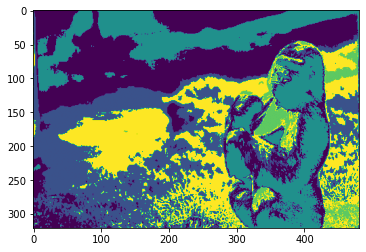

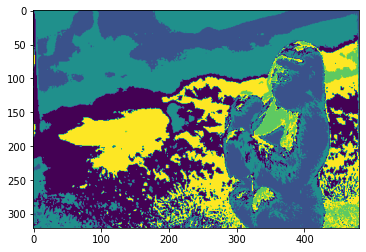

In [ ]:
image1 = from_1d_to_2d(clustering_assignment, images_data[index])
plt.imshow(image1)
plt.show()

image2 = from_1d_to_2d(kmeans.labels_, images_data[index])
plt.imshow(image2)
plt.show()

# **Big Picture**

# **4A**

In [ ]:
from sklearn.cluster import SpectralClustering
#Five Chosen images indices
indices = [0,1,2,3,4]
k=5

In [ ]:
def bigPic_kmeans(images_data,pixels_data,seg_data,indices,k) : 
   for i in indices :
      print("GroundTruth")
      show_segmentation(seg_data[i])

      print("Implemented")
      cluster_assignment = k_means(pixels_data[i], k, 0.00001)
      image1 = from_1d_to_2d(cluster_assignment, images_data[i])
      plt.imshow(image1)
      plt.show()
      entr_avg = 0
      fmeasure_avg = 0
      for j in range(len(seg_data[i])):
        print("Ground truth number : ", j + 1)
        cond_entropy, f_measure = get_measures(seg_data[i][j].flatten(), cluster_assignment)
        print("Conditional entropy: ", cond_entropy)
        print("F-measure: ", f_measure)
        entr_avg += cond_entropy
        fmeasure_avg += f_measure
      print("Conditional entropy the average of the M trials : ", entr_avg / len(seg_data[i]))
      print("f-measure the average of the M trials : ", fmeasure_avg / len(seg_data[i]))
      print("______________________________________________________________________")

In [ ]:
bigPic_kmeans(images_data,pixels_data,seg_data,indices,k)

# **4B**

In [ ]:
def bigPic_normalizedCut(label,images_data,pixels_data,seg_data,i) :
        print("GroundTruth")
        show_segmentation(seg_data[i])

        print("Implemented")
        image1 = from_1d_to_2d(label, images_data[i])
        plt.imshow(image1)
        plt.show()

        entr_avg = 0
        fmeasure_avg = 0
        for j in range(len(seg_data[i])):
          print("Ground truth number : ", j + 1)
          cond_entropy, f_measure = get_measures(seg_data[i][j].flatten(), label)
          print("Conditional entropy: ", cond_entropy)
          print("F-measure: ", f_measure)
          entr_avg += cond_entropy
          fmeasure_avg += f_measure
        print("Conditional entropy the average of the M trials : ", entr_avg / len(seg_data[i]))
        print("f-measure the average of the M trials : ", fmeasure_avg / len(seg_data[i]))
        print("______________________________________________________________________")

In [ ]:
c0 = SpectralClustering(n_clusters=k,random_state=1,affinity='nearest_neighbors',n_neighbors=k).fit(pixels_data[indices[0]])

In [ ]:
bigPic_normalizedCut(c0,images_data,pixels_data,seg_data,indices[0])

In [ ]:
c1 = SpectralClustering(n_clusters=k,random_state=1,affinity='nearest_neighbors',n_neighbors=k).fit(pixels_data[indices[1]])

In [ ]:
bigPic_normalizedCut(c1,images_data,pixels_data,seg_data,indices[1])

In [ ]:
c2 = SpectralClustering(n_clusters=k,random_state=1,affinity='nearest_neighbors',n_neighbors=k).fit(pixels_data[indices[2]])

In [ ]:
bigPic_normalizedCut(c2,images_data,pixels_data,seg_data,indices[2])

In [ ]:
c3 = SpectralClustering(n_clusters=k,random_state=1,affinity='nearest_neighbors',n_neighbors=k).fit(pixels_data[indices[3]])

In [ ]:
bigPic_normalizedCut(c3,images_data,pixels_data,seg_data,indices[3])

In [ ]:
c4 = SpectralClustering(n_clusters=k,random_state=1,affinity='nearest_neighbors',n_neighbors=k).fit(pixels_data[indices[4]])

In [ ]:
bigPic_normalizedCut(c4,images_data,pixels_data,seg_data,indices[4])

# **Extra**

In [ ]:
# getting indexes of image
indices = np.indices(images_data[index].shape[:2])
image = np.dstack((images_data[index], indices[0], indices[1]))
pixel = image.reshape((-1,5))
pixel = np.float32(pixel)
print("pixels ", pixel)
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()
pixels_scaled = trans.fit_transform(pixel)
print("pixels ", pixels_scaled)

In [ ]:
clustering_assignment_bonus = k_means(pixels_scaled, 5, 0.00001)
print("cluster assignment implemented",clustering_assignment)

In [ ]:
image1 = from_1d_to_2d(clustering_assignment_bonus, images_data[index])
plt.imshow(image1)
plt.show()

In [ ]:
print(get_measures(seg_data[index][1].flatten(), clustering_assignment_bonus))

In [ ]:
for i in [0,1,2,3,4]:
  indices = np.indices(images_data[i].shape[:2])
  img = np.dstack((images_data[i], indices[0], indices[1]))
  pixel = img.reshape((-1,5))
  pixel = np.float32(pixel)
  trans = MinMaxScaler()
  pixels_scaled = trans.fit_transform(pixel)
  clustering_assignment_bonus = k_means(pixels_scaled, 5, 0.00001)
  image_bonus = from_1d_to_2d(clustering_assignment_bonus, images_data[i])
  plt.imshow(image_bonus)
  plt.show()
  entr_avg = 0
  fmeasure_avg = 0
  for j in range(len(seg_data[i])):
    entropy, f_measure_bon = get_measures(seg_data[i][j].flatten(), clustering_assignment_bonus)
    print("Conditional entropy: ", entropy)
    print("F-measure: ", f_measure_bon)
    entr_avg += entropy
    fmeasure_avg += f_measure_bon
  print("Conditional entropy the average of the M trials : ", entr_avg / len(seg_data[i]))
  print("f-measure the average of the M trials : ", fmeasure_avg / len(seg_data[i]))